In [1]:
import pandas as pd
import numpy as np

# Set a seed for reproducibility
np.random.seed(42)

num_users = 2000

# Generate synthetic data
data = {
    'User_ID': np.arange(1, num_users + 1),
    'Tenure_Months': np.random.randint(1, 25, num_users), # 1 to 24 months
    'Avg_Session_Min': np.random.uniform(10, 120, num_users).round(2), # 10 to 120 minutes
    'Skip_Rate': np.random.uniform(0.0, 1.0, num_users).round(2), # 0.0 to 1.0
    'Playlist_Creates': np.random.randint(0, 20, num_users), # 0 to 19 playlists
    'Ad_Interrupts_Per_Hour': np.random.randint(0, 10, num_users) # 0 to 9 ads
}

df = pd.DataFrame(data)

# Initialize 'Churned' column (default to 0: Stayed)
df['Churned'] = 0

# Apply Business Logic

# 1. The 'Rage Quit': If Skip_Rate > 0.6 AND Ad_Interrupts_Per_Hour > 4, set Churned to 1
df.loc[(df['Skip_Rate'] > 0.6) & (df['Ad_Interrupts_Per_Hour'] > 4), 'Churned'] = 1

# 2. The 'Loyalist': If Playlist_Creates > 5, set Churned to 0 (This overrides Rage Quit if a loyalist also met rage quit criteria)
df.loc[df['Playlist_Creates'] > 5, 'Churned'] = 0

# 3. The 'Trial Drop': High churn probability if Tenure_Months < 2
# For users with tenure less than 2 months and not already set to 'Stayed' by Loyalist rule,
# apply a high probability of churn (e.g., 70% chance)
trial_drop_condition = (df['Tenure_Months'] < 2) & (df['Churned'] == 0)
churn_probability_trial_drop = 0.7 # 70% chance of churn for trial drops
churn_indices = df[trial_drop_condition].index

# Randomly select a subset of these indices to set to churned
num_to_churn = int(len(churn_indices) * churn_probability_trial_drop)
churn_now_indices = np.random.choice(churn_indices, num_to_churn, replace=False)
df.loc[churn_now_indices, 'Churned'] = 1

# Display the first 5 rows of the DataFrame
display(df.head())

,User_ID,Tenure_Months,Avg_Session_Min,Skip_Rate,Playlist_Creates,Ad_Interrupts_Per_Hour,Churned
0,1,7,95.36,0.23,18,9,0
1,2,20,54.58,0.53,11,4,0
2,3,15,76.20,0.83,17,1,0
3,4,11,79.58,0.46,16,9,0
4,5,8,51.01,0.28,10,5,0


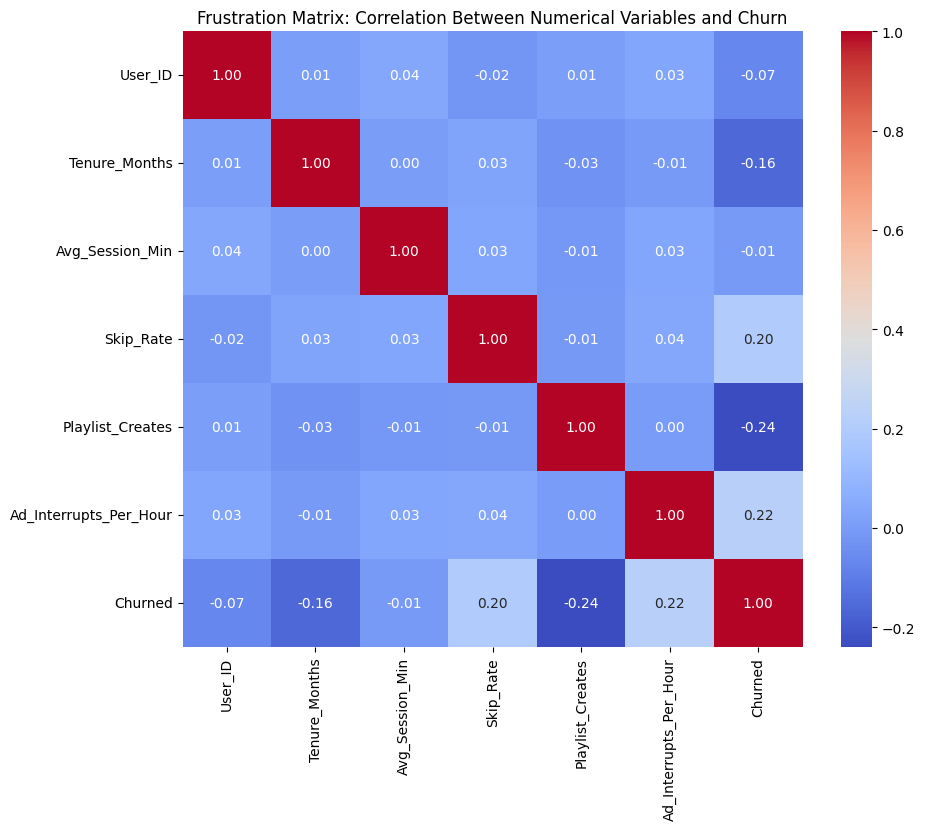

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# Frustration Matrix (Heatmap)
plt.figure(figsize=(10, 8))
numerical_df = df.select_dtypes(include=np.number) # Select only numerical columns
correlation_matrix = numerical_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Frustration Matrix: Correlation Between Numerical Variables and Churn')
plt.show()

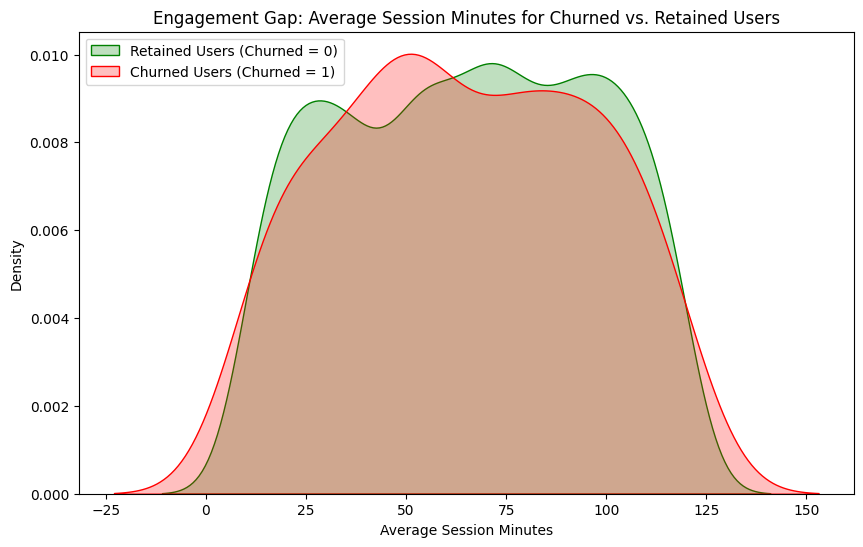

In [3]:
# Engagement Gap (KDE Plot)
plt.figure(figsize=(10, 6))
sns.kdeplot(df.loc[df['Churned'] == 0, 'Avg_Session_Min'], color='green', fill=True, label='Retained Users (Churned = 0)')
sns.kdeplot(df.loc[df['Churned'] == 1, 'Avg_Session_Min'], color='red', fill=True, label='Churned Users (Churned = 1)')
plt.title('Engagement Gap: Average Session Minutes for Churned vs. Retained Users')
plt.xlabel('Average Session Minutes')
plt.ylabel('Density')
plt.legend()
plt.show()

In [4]:
# Identify High-Value Churners
high_value_churners = df[(df['Churned'] == 1) & (df['Playlist_Creates'] > 3)]

print(f"Number of High-Value Churners: {len(high_value_churners)}")

# Calculate Revenue Impact
arpu_monthly = 10  # Average Revenue Per User per month
annual_revenue_lost = len(high_value_churners) * arpu_monthly * 12

print(f"Annual Revenue Lost from High-Value Churners: ${annual_revenue_lost:,.2f}")

Number of High-Value Churners: 100
Annual Revenue Lost from High-Value Churners: $12,000.00


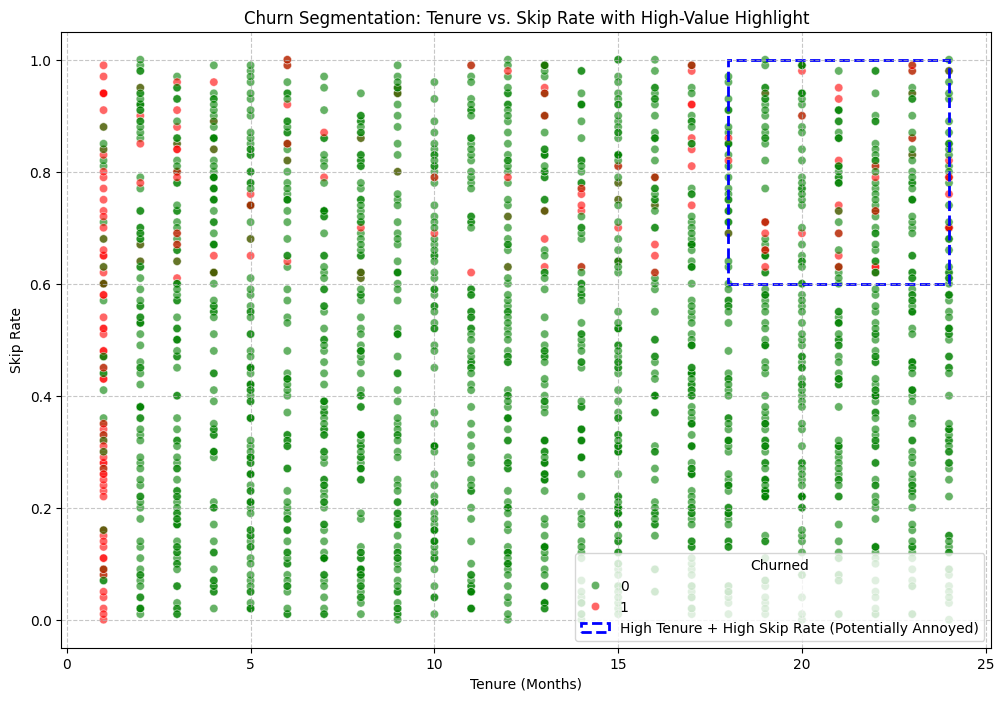

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle

plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x='Tenure_Months', y='Skip_Rate', hue='Churned', palette={0: 'green', 1: 'red'}, alpha=0.6)

plt.title('Churn Segmentation: Tenure vs. Skip Rate with High-Value Highlight')
plt.xlabel('Tenure (Months)')
plt.ylabel('Skip Rate')

# Define the area for 'High Tenure' + 'High Skip Rate'
# These thresholds are illustrative; adjust based on data distribution or business logic.
high_tenure_threshold = 18
high_skip_rate_threshold = 0.6

# Add a rectangle to highlight the 'annoyed' segment
plt.gca().add_patch(Rectangle(
    (high_tenure_threshold, high_skip_rate_threshold), # (x, y) lower-left corner
    df['Tenure_Months'].max() - high_tenure_threshold, # Width
    df['Skip_Rate'].max() - high_skip_rate_threshold,  # Height
    fill=False,      # Don't fill the rectangle
    edgecolor='blue', # Color of the border
    linewidth=2,     # Thickness of the border
    linestyle='--',  # Style of the border
    label='High Tenure + High Skip Rate (Potentially Annoyed)'
))

plt.legend(title='Churned')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Prepare the data
# Features (X): Drop User_ID and the target variable 'Churned'
X = df.drop(['User_ID', 'Churned'], axis=1)
y = df['Churned']

# Split data into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train a RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions and evaluate the model (optional, but good practice)
y_pred = model.predict(X_test)
print("Model Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Model Accuracy: 0.9825

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99       362
           1       0.86      0.97      0.91        38

    accuracy                           0.98       400
   macro avg       0.93      0.98      0.95       400
weighted avg       0.98      0.98      0.98       400



/tmp/ipython-input-805478703.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importances, palette=colors)


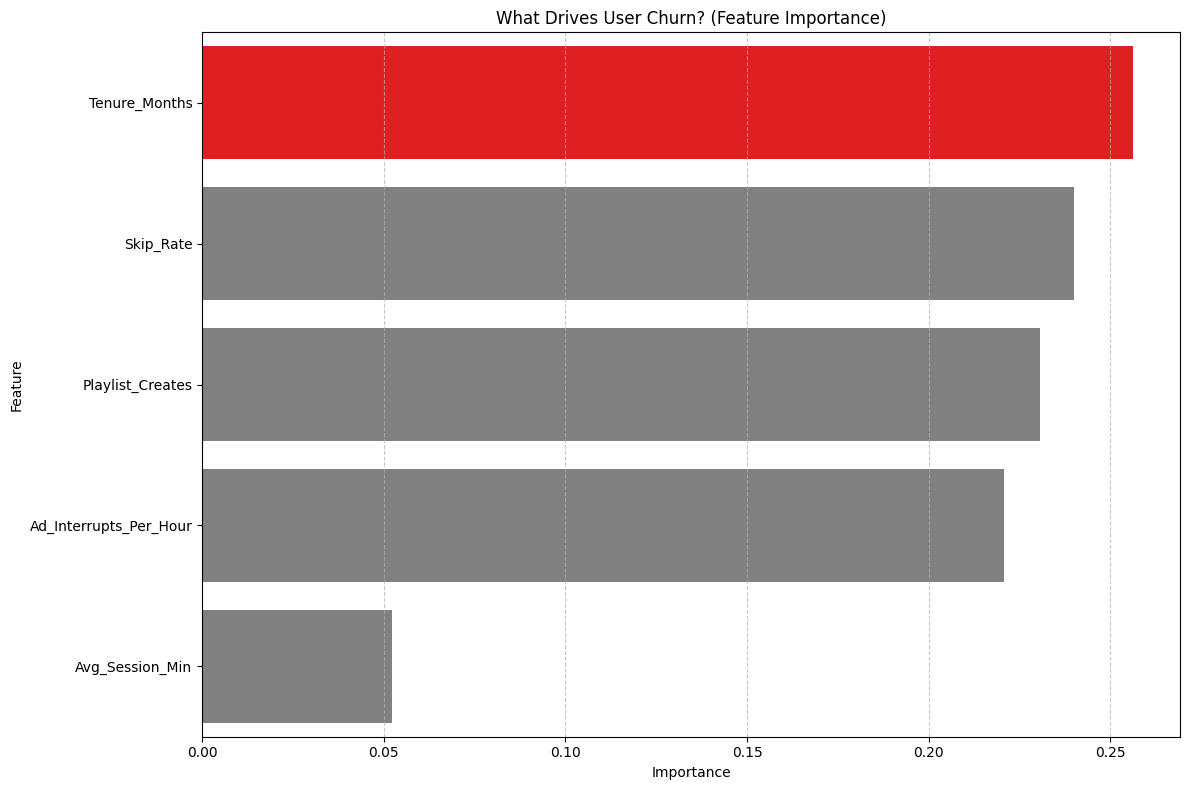

In [7]:
# Extract Feature Importances
feature_importances = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
})

# Sort by importance
feature_importances = feature_importances.sort_values(by='importance', ascending=False)

# Visual: Horizontal Bar Chart
plt.figure(figsize=(12, 8))

# Define colors: top bar red, others grey
colors = ['red'] + ['grey'] * (len(feature_importances) - 1)

sns.barplot(x='importance', y='feature', data=feature_importances, palette=colors)
plt.title('What Drives User Churn? (Feature Importance)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Original Revenue at Risk: $23,400.00
New Revenue at Risk (After 20% Skip_Rate Reduction): $17,280.00
PROJECTED SAVINGS: $6,120.00


/tmp/ipython-input-2074156311.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Scenario', y='Value', data=revenue_data, palette=['red', 'green'])


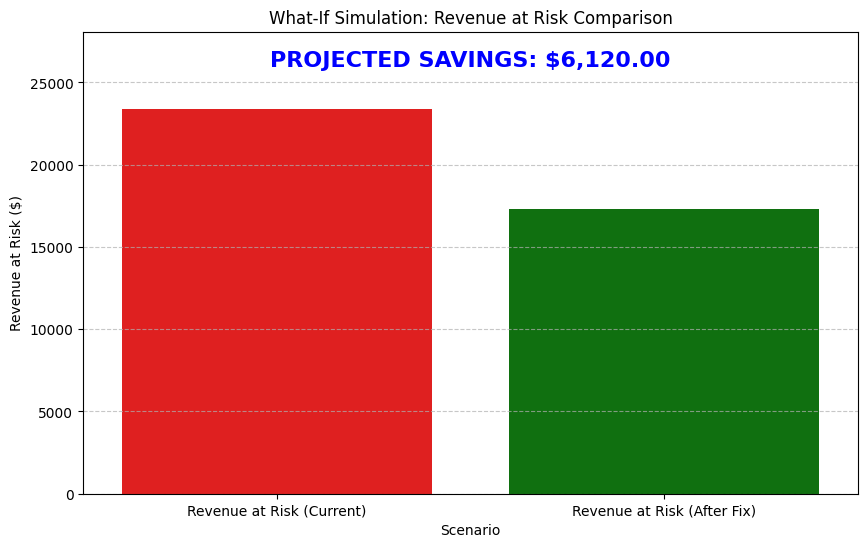

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --- 1. The Scenario: Create df_fixed with reduced Skip_Rate ---
df_fixed = df.copy()
df_fixed['Skip_Rate'] = df_fixed['Skip_Rate'] * 0.8
df_fixed['Skip_Rate'] = df_fixed['Skip_Rate'].clip(lower=0.0) # Ensure Skip_Rate doesn't go below 0

# --- 2. The Prediction: Use the trained model to predict new churn probability ---
# Prepare features for original and fixed scenarios
X_original_pred = df.drop(['User_ID', 'Churned'], axis=1)
X_fixed_pred = df_fixed.drop(['User_ID', 'Churned'], axis=1)

# Predict churn for original and fixed scenarios
df['Predicted_Churn_Original'] = model.predict(X_original_pred)
df_fixed['Predicted_Churn_Fixed'] = model.predict(X_fixed_pred)

# --- 3. Financial Impact Analysis ---
# Assuming LTV is the annual revenue per user (ARPU * 12 months)
# arpu_monthly is already defined in the kernel state from a previous step (value: 10)
ltv_per_user = arpu_monthly * 12 # $10/month * 12 months = $120 per user per year

# Calculate Original Revenue at Risk
original_churners = df[df['Predicted_Churn_Original'] == 1]
original_revenue_at_risk = len(original_churners) * ltv_per_user

# Calculate New Revenue at Risk (after the fix)
fixed_churners = df_fixed[df_fixed['Predicted_Churn_Fixed'] == 1]
new_revenue_at_risk = len(fixed_churners) * ltv_per_user

# Calculate Total Saved Revenue
total_saved_revenue = original_revenue_at_risk - new_revenue_at_risk

print(f"Original Revenue at Risk: ${original_revenue_at_risk:,.2f}")
print(f"New Revenue at Risk (After 20% Skip_Rate Reduction): ${new_revenue_at_risk:,.2f}")
print(f"PROJECTED SAVINGS: ${total_saved_revenue:,.2f}")

# --- 4. Strategic Visualization ---
revenue_data = pd.DataFrame({
    'Scenario': ['Revenue at Risk (Current)', 'Revenue at Risk (After Fix)'],
    'Value': [original_revenue_at_risk, new_revenue_at_risk]
})

plt.figure(figsize=(10, 6))
sns.barplot(x='Scenario', y='Value', data=revenue_data, palette=['red', 'green'])
plt.title('What-If Simulation: Revenue at Risk Comparison')
plt.ylabel('Revenue at Risk ($)')
plt.ylim(0, max(original_revenue_at_risk, new_revenue_at_risk) * 1.2) # Adjust y-lim for annotation

# Add the annotation for projected savings
plt.text(0.5, max(original_revenue_at_risk, new_revenue_at_risk) * 1.1,
         f'PROJECTED SAVINGS: ${total_saved_revenue:,.2f}',
         ha='center', va='bottom', fontsize=16, color='blue', weight='bold')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()